In [27]:
from PyEcoLib.simulator import Simulator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import kurtosis, skew
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

%matplotlib inline

In [28]:
ncells = 50
doubling_time = 20 #min
gr = np.log(2)/doubling_time 
mean_size = 4 # micron
div_steps = 20

tmax = 200 #min
sample_time = 0.004 #min, 5000 frames per gen

In [29]:
start = time.time()
sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataTimer.csv")
print('It took', int(time.time()-start), 'seconds.')

Cells initialized
Cells initialized
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
It took 7 seconds.


In [30]:
data1 = pd.read_csv("./data/dataTimer.csv")
data1.head(10)

,time,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,...,Cell41,Cell42,Cell43,Cell44,Cell45,Cell46,Cell47,Cell48,Cell49,Cell50
0,0.000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000
1,0.004,4.0006,4.0005,4.0005,4.0005,4.0005,4.0004,4.0003,4.0004,4.0004,...,4.0006,4.0005,4.0006,4.0005,4.0004,4.0006,4.0004,4.0006,4.0004,4.0004
2,0.008,4.0012,4.0011,4.0010,4.0010,4.0010,4.0008,4.0007,4.0008,4.0008,...,4.0013,4.0011,4.0013,4.0011,4.0008,4.0012,4.0009,4.0012,4.0008,4.0009
3,0.012,4.0018,4.0017,4.0016,4.0015,4.0015,4.0013,4.0011,4.0012,4.0013,...,4.0019,4.0017,4.0020,4.0016,4.0013,4.0018,4.0013,4.0019,4.0013,4.0014
4,0.016,4.0024,4.0022,4.0021,4.0020,4.0020,4.0017,4.0015,4.0016,4.0017,...,4.0026,4.0023,4.0027,4.0022,4.0017,4.0024,4.0018,4.0025,4.0017,4.0019
5,0.020,4.0030,4.0028,4.0027,4.0025,4.0026,4.0022,4.0019,4.0020,4.0022,...,4.0033,4.0029,4.0034,4.0027,4.0022,4.0030,4.0023,4.0032,4.0021,4.0024
6,0.024,4.0036,4.0034,4.0032,4.0030,4.0031,4.0026,4.0023,4.0024,4.0026,...,4.0039,4.0035,4.0041,4.0033,4.0026,4.0036,4.0027,4.0038,4.0026,4.0028
7,0.028,4.0042,4.0040,4.0037,4.0035,4.0036,4.0030,4.0027,4.0028,4.0031,...,4.0046,4.0040,4.0048,4.0038,4.0030,4.0042,4.0032,4.0045,4.0030,4.0033
8,0.032,4.0048,4.0045,4.0043,4.0040,4.0041,4.0035,4.0031,4.0032,4.0035,...,4.0052,4.0046,4.0055,4.0044,4.0035,4.0048,4.0036,4.0051,4.0034,4.0038
9,0.036,4.0054,4.0051,4.0048,4.0045,4.0047,4.0039,4.0035,4.0037,4.0039,...,4.0059,4.0052,4.0062,4.0049,4.0039,4.0054,4.0041,4.0057,4.0039,4.0043


In [31]:
timearray=data1.time.unique()
print(timearray)
test = data1.iloc[:, 0]
test

[0.00000e+00 4.00000e-03 8.00000e-03 ... 1.99996e+02 2.00000e+02
 2.00004e+02]


0          0.000
1          0.004
2          0.008
3          0.012
4          0.016
          ...   
49997    199.988
49998    199.992
49999    199.996
50000    200.000
50001    200.004
Name: time, Length: 50002, dtype: float64

In [32]:
# data1_m = data1.melt('time', var_name='cols', value_name='cells')
# sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# plt.show()

In [33]:
def find_division(data, i, height=None, threshold=None, distance=None):
    idx, _ = scipy.signal.find_peaks(data.iloc[:, i], height=height, threshold=threshold, distance=distance)
    return idx

def down_sample(data, n):
    samples = data.iloc[::n, :].reset_index(drop=True)
    return samples

def get_prop(data, i):
    idx = find_division(data, i)
    div_times = np.diff(data.iloc[:, 0].to_numpy()[idx])
    return div_times

def xunder(ts, thresh, filt=True):
    if filt:
        # x = gaussian_filter1d(ts, 5) < thresh
        x = savgol_filter(ts, 10, 1) < thresh
    else:
        x = ts < thresh
    return x.argmin() if x.any() else 0

In [34]:
# ds_1 = down_sample(data1, 2500)
# ds1_m = ds_1.melt('time', var_name='cols', value_name='cells')
# sns.lineplot(data=ds1_m, x="time", y="cells", hue='cols')
# plt.show()

[21.976 16.652 15.304 14.908 31.356 29.032 11.512 25.144 15.704]


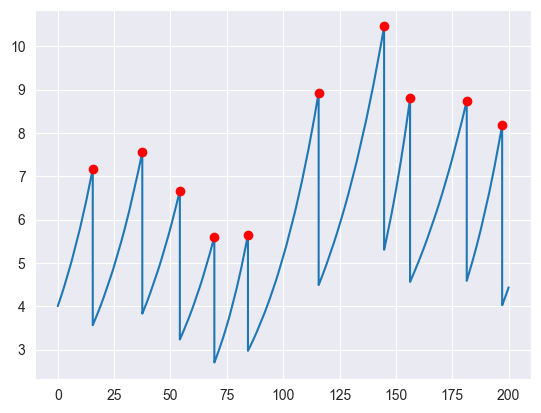

In [35]:
idx = find_division(data1, 1)
plt.plot(data1.iloc[:, 0], data1.iloc[:, 1])
plt.plot(data1.iloc[:, 0].to_numpy()[idx], data1.iloc[:, 1].to_numpy()[idx], 'ro')
print(get_prop(data1, 1))
plt.show()

0.9376157912008566


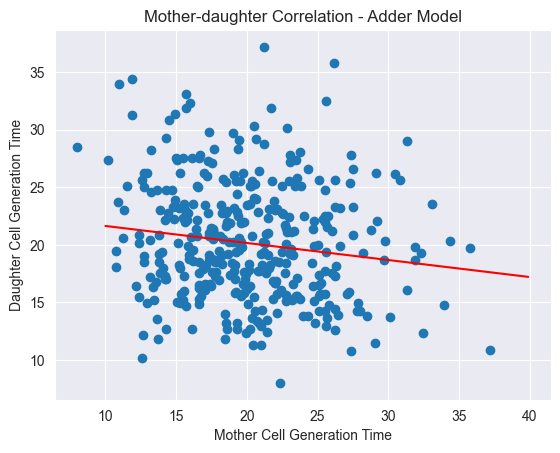

In [36]:
mothers_tau1 = []
daughters_tau1 = []
for i in range(ncells):
    true_div_times = get_prop(data1, i+1) 
    tmother = true_div_times[:-1]
    tdaughter = true_div_times[1:]
    mothers_tau1.extend(tmother)
    daughters_tau1.extend(tdaughter)
# slope1, _, __, ___, ____ = linregress(mothers_tau1, daughters_tau1)
slope1, _, __, ___, ____ = linregress(daughters_tau1, mothers_tau1)
true_c = slope1

test_x = np.arange(10, 40, 0.1)
plt.title("Mother-daughter Correlation - Adder Model")
plt.ylabel("Daughter Cell Generation Time")
plt.xlabel("Mother Cell Generation Time")
plt.plot(mothers_tau1, daughters_tau1, 'o')
plt.plot(test_x, slope1*test_x + _, 'red')
print(1/(np.mean(np.array(mothers_tau1)/np.array(daughters_tau1))))

plt.show()

In [37]:
time_res = np.arange(1/250, 9, 0.05) # time interval in minutes

errors_t = []
errors_v = []
mean_true = []
var_true = []
mean_est = []
var_est = []
mean2_true = []
var2_true = []
mean2_est = []
var2_est = []
sk_true = []
kur_true = []
sk_est = []
kur_est = []
sk2_true = []
kur2_true = []
sk2_est = []
kur2_est = []

c_est = []
fitness_est = []

true_div_times = [x for i in range(ncells) for x in get_prop(data1, i+1)]
for t in time_res:
    
    ds = down_sample(data1, n=round(t*250))
    div_times = [get_prop(ds, i+1) for i in range(ncells)]
    
    bin_number = 50
    
    est_div_times = [item for sublist in div_times for item in sublist]
    m1 = np.mean(true_div_times)
    m2 = np.mean(est_div_times)
    v1 = np.var(true_div_times)
    v2 = np.var(est_div_times)
    mean_true.append(m1)
    mean_est.append(m2)
    var_true.append(v1)
    var_est.append(v2)
    sk_true.append(skew(true_div_times))
    sk_est.append(skew(est_div_times))
    # print(skew(est_div_times) - skew(true_div_times))
    kur_true.append(kurtosis(true_div_times))
    kur_est.append(kurtosis(est_div_times))
    
    mothers_tau = []
    daughters_tau = []
    for sublist in div_times:
        tmother = sublist[:-1]
        tdaughter = sublist[1:]
        mothers_tau.extend(tmother)
        daughters_tau.extend(tdaughter)
    slope, _, __, ___, ____ = linregress(mothers_tau, daughters_tau)
    mother_daughter_c = slope
    c_est.append(mother_daughter_c)
    
    fitness = 2 * np.log(2) / m2 / (1 + np.sqrt(1 - 2 * np.log(2) * v2 / m2**2 * (1 + mother_daughter_c) / (1 - mother_daughter_c)))
    fitness_est.append(fitness)
    
    count1, bins = np.histogram(np.array(est_div_times), bin_number)
    count2, bins = np.histogram(np.array(true_div_times), bins=bins)
    errors_t.append(sum(abs(count1 - count2)))

1.0


C:\Users\ErezL\AppData\Local\Temp\ipykernel_73648\1395742825.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


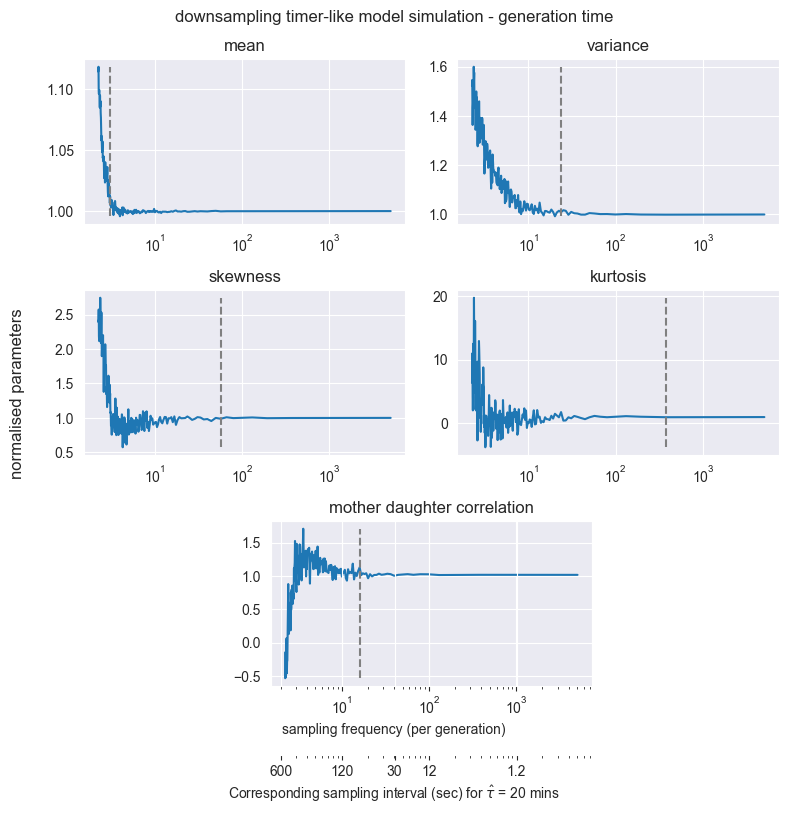

In [38]:
fig = plt.figure(layout="constrained", figsize=(8, 8))
mosaic = """
    0011
    0011
    2233
    2233
    .44.
    .44.
    """
axes = fig.subplot_mosaic(mosaic)
fig.suptitle("downsampling timer-like model simulation - generation time")
axes['0'].plot(mean_true[0]/time_res, mean_est/mean_true[0], label="est")
axes['0'].set_xscale("log")
idx1 = xunder(abs(mean_est/mean_true[0] - 1), 0.01)
axes['0'].vlines(mean_true[0]/time_res[idx1], min(mean_est/mean_true[0]), max(mean_est/mean_true[0]), color='0.5', linestyles='dashed')
axes['0'].set_title("mean")

axes['1'].plot(mean_true[0]/time_res, var_est/var_true[0], label="est")
axes['1'].set_xscale("log")
idx2 = xunder(abs(var_est/var_true[0] - 1), 0.01)
axes['1'].vlines(mean_true[0]/time_res[idx2], min(var_est/var_true[0]), max(var_est/var_true[0]), color='0.5', linestyles='dashed')
axes['1'].set_title("variance")

axes['2'].plot(mean_true[0]/time_res, np.array(sk_est)/sk_true[0], label="est")
print((np.array(sk_est)/sk_true[0])[0])
axes['2'].set_xscale("log")
idx3 = xunder(abs(np.array(sk_est)/sk_est[0] - 1), 0.01, filt=False)
axes['2'].vlines(mean_true[0]/time_res[idx3], min(np.array(sk_est)/sk_true[0]), max(np.array(sk_est)/sk_true[0]), color='0.5', linestyles='dashed')
axes['2'].set_title("skewness")

axes['3'].plot(mean_true[0]/time_res, np.array(kur_est)/kur_true[0], label="est")
axes['3'].set_xscale("log")
idx4 = xunder(abs(np.array(kur_est)/kur_est[0]- 1), 0.01, filt=False)
axes['3'].vlines(mean_true[0]/time_res[idx4], min(np.array(kur_est)/kur_true[0]), max(np.array(kur_est)/kur_true[0]), color='0.5', linestyles='dashed')
axes['3'].set_title("kurtosis")
# 
axes['4'].plot(mean_true[0]/time_res, np.array(c_est)/true_c, label="est")
axes['4'].set_xscale("log")
idx5 = xunder(abs(np.array(c_est)/true_c - 1), 0.05)
axes['4'].vlines(mean_true[0]/time_res[idx5], min(np.array(c_est)/true_c), max(np.array(c_est)/true_c), color='0.5', linestyles='dashed')
axes['4'].set_title("mother daughter correlation")

fig.text(0.5, 0.08, 'sampling frequency (per generation)', ha='center', va='center')
fig.supylabel("normalised parameters")
fig.text(0.5, 0, r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

ax20 = axes['4'].twiny()
ax20.set_xscale("log")
newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax20.set_xticks(newpos)
ax20.set_xticklabels(newlabel)

ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax20.spines['bottom'].set_position(('outward', 50))
# ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
ax20.set_xlim(axes['4'].get_xlim())

plt.tight_layout()
plt.show()

In [56]:
# ncells = 5
# doubling_time = 20 #min
# gr = np.log(2)/doubling_time 
# mean_size = 4 # micron
# div_steps = 20
# 
# tmax = 200 #min
# sample_time = 0.003 #min
# 
# start = time.time()
# sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
# sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataAdder.csv")
# print('It took', int(time.time()-start), 'seconds.')

In [57]:
# data2 = pd.read_csv("./data/dataAdder.csv")
# data2_m = data2.melt('time', var_name='cols', value_name='cells')
# # sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# sns.lineplot(data=data2_m, x="time", y="cells",  hue='cols')
# plt.show()

In [58]:
# ncells = 1
# doubling_time = 20 #min
# gr = np.log(2)/doubling_time 
# mean_size = 4 # micron
# div_steps = 20
# 
# tmax = 200 #min
# sample_time = 0.003 #min
# 
# start = time.time()
# sim = Simulator(ncells=ncells, gr=gr, sb=mean_size, steps=div_steps, CV2div = 0.001, CV2gr = 0.02, lamb=1, V0array=None)
# sim.divstrat(tmax=tmax, nameDSM = "./data/dataDSM.csv")
# sim.szdyn(tmax=tmax, sample_time=sample_time, nameCRM = "./data/dataAdder.csv")
# print('It took', int(time.time()-start), 'seconds.')

In [59]:
# data3 = pd.read_csv("./data/dataAdder.csv")
# data3_m = data3.melt('time', var_name='cols', value_name='cells')
# # sns.lineplot(data=data1_m, x="time", y="cells", hue='cols')
# sns.lineplot(data=data3_m, x="time", y="cells",  hue='cols')
# plt.show()